In [8]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from sklearn.metrics import precision_recall_curve, f1_score, classification_report

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from sklearn.utils import class_weight

In [2]:
def charge_npy(path):
    X = np.load(path)
    y = np.load(path.replace('X', 'y'))
    return X, y

In [3]:
# charge y_train.npy in Facenet Embeddings/Train/y_train.npy
path_train = '../../../Facenet Embeddings/Train/X_train.npy'
path_val = '../../../Facenet Embeddings/Val/X_val.npy'
path_test = '../../../Facenet Embeddings/Test/X_test.npy'
X_train, y_train = charge_npy(path_train)
X_val, y_val = charge_npy(path_val)
X_test, y_test = charge_npy(path_test)

n_frames = 5
embedding_dim = 128

X_train = X_train.reshape((-1, n_frames, embedding_dim))
y_train = y_train[:, 4:8]
y_train = np.mean(y_train.reshape(-1, 5, 4), axis=1)
y_train = np.argmax(y_train, axis=1)
## if in the first or second position exists a 1, then y is 0 and only has a shape of 1, else 1
##y_train = np.where((y_train[:, 3] == 1), 1, 0).reshape(-1, 1)

X_val = X_val.reshape((-1, n_frames, embedding_dim)) 
y_val = y_val[:, 4:8]
y_val = np.mean(y_val.reshape(-1, 5, 4), axis=1)
y_val = np.argmax(y_val, axis=1)
##y_val = np.where((y_val[:, 3] == 1), 1, 0).reshape(-1, 1)

X_test = X_test.reshape((-1, n_frames, embedding_dim))  
y_test = y_test[:, 4:8]
y_test = np.mean(y_test.reshape(-1, 5, 4), axis=1)
y_test = np.argmax(y_test, axis=1)

#y_test = np.mean(y_test.reshape(-1, 5, 4), axis=1)
##y_test = np.where((y_test[:, 3] == 1), 1, 0).reshape(-1, 1)

X = np.concatenate((X_train, X_val, X_test), axis=0)
y = np.concatenate((y_train, y_val, y_test), axis=0)

In [4]:
# Divide data in train, val and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape
#X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5711, 5, 128), (1428, 5, 128), (1785, 5, 128), (5711,), (1428,), (1785,))

In [5]:
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [10]:
# Callback EarlyStopping y ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=250, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, verbose=1)

# Definimos el modelo CNN
def build_bilstm_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Primera capa BiLSTM
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(inputs)
    
    # Segunda capa BiLSTM
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(x)
    
    # Pooling global
    x = GlobalAveragePooling1D()(x)
    
    # Denso + Dropout
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(4, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(1e-4), metrics=["accuracy"])
    
    return model

# Creamos y entrenamos el modelo
model = build_bilstm_model((X_train.shape[1], X_train.shape[2]))

history = model.fit(
    X_train,
    y_train,
    class_weight=class_weights,
    epochs=1000,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/1000
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.2736 - loss: 1.3476 - val_accuracy: 0.3466 - val_loss: 1.3439 - learning_rate: 1.0000e-04
Epoch 2/1000
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2979 - loss: 1.3474 - val_accuracy: 0.3999 - val_loss: 1.3283 - learning_rate: 1.0000e-04
Epoch 3/1000
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3230 - loss: 1.2596 - val_accuracy: 0.3817 - val_loss: 1.3205 - learning_rate: 1.0000e-04
Epoch 4/1000
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3160 - loss: 1.4275 - val_accuracy: 0.3683 - val_loss: 1.3167 - learning_rate: 1.0000e-04
Epoch 5/1000
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3310 - loss: 1.3321 - val_accuracy: 0.3711 - val_loss: 1.3052 - learning_rate: 1.0000e-04
Epoch 6/1000
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3389 - loss: 1.2730 - val_accuracy: 0.3697 - val_loss: 1.2937 - learning_rate: 1.0000e-04
Epoch 7/1000
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 

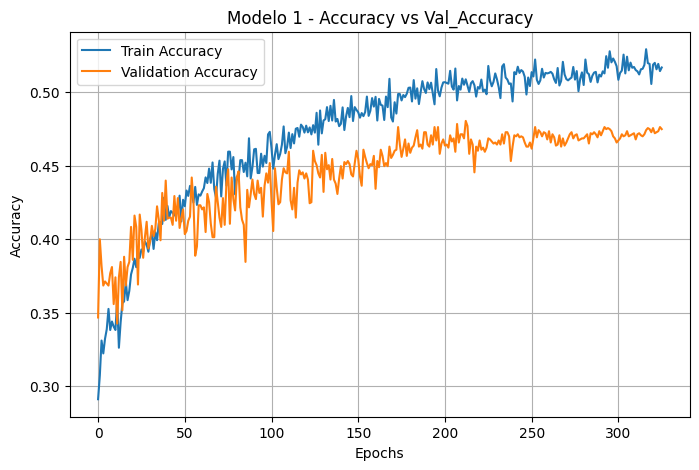

In [11]:
# Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Modelo {1} - Accuracy vs Val_Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

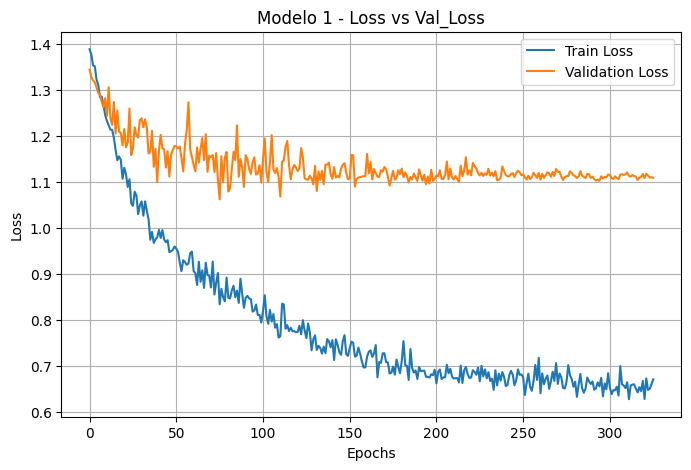

In [12]:
# Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Modelo {1} - Loss vs Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Predicciones individuales de cada modelo
preds = model.predict(X_test)
final_preds = np.argmax(preds, axis=1)

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


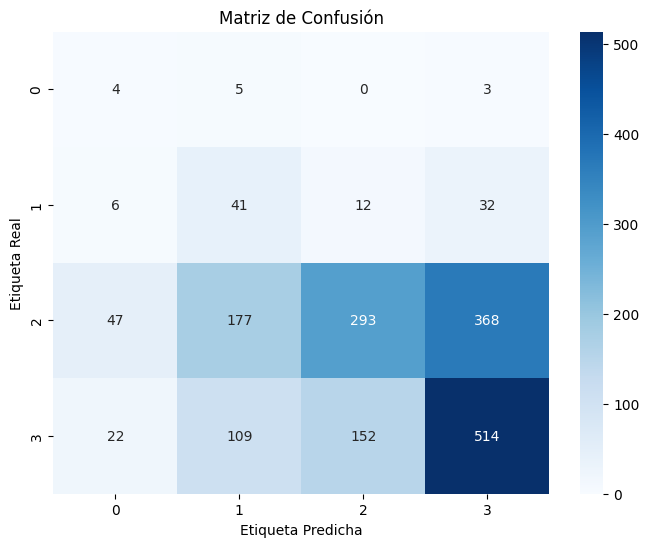

In [14]:
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

In [15]:
# view classification report
print(classification_report(y_test, final_preds, digits=3))

              precision    recall  f1-score   support

           0      0.051     0.333     0.088        12
           1      0.123     0.451     0.194        91
           2      0.641     0.331     0.437       885
           3      0.561     0.645     0.600       797

    accuracy                          0.477      1785
   macro avg      0.344     0.440     0.330      1785
weighted avg      0.575     0.477     0.495      1785



In [16]:
# Give metric of UAR
def UAR(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    uar = np.mean(np.diag(cm) / np.sum(cm, axis=1))
    return uar

uar = UAR(y_test, final_preds)
print(f'UAR: {uar:.4f}')

UAR: 0.4400
